# Sentiment Analysis
Importing all the necessary libraries and packeges required.

In [ ]:
!pip install bertopic

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from bertopic import BERTopic
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.impute import SimpleImputer, KNNImputer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

Loading the dataset

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/reviews.xlsx'
df = pd.read_excel(file_path)
print(df.head())

   Unnamed: 0   Airline Name Overall_Rating  \
0           0    AB Aviation              9   
1           1    AB Aviation              1   
2           2    AB Aviation              1   
3           3  Adria Airways              1   
4           4  Adria Airways              1   

                            Review_Title          Review Date  Verified  \
0                "pretty decent airline"   11th November 2019      True   
1                   "Not a good airline"       25th June 2019      True   
2         "flight was fortunately short"       25th June 2019      True   
3    "I will never fly again with Adria"  28th September 2019     False   
4  "it ruined our last days of holidays"  24th September 2019      True   

                                              Review       Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...            NaN   
1   Moroni to Anjouan. It is a very small airline...           E120   
2    Anjouan to Dzaoudzi. A very small airline an... 

# Explanatory Data Analysis(EDA)

In [ ]:
df.shape

(23171, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              23171 non-null  int64         
 1   Airline Name            23171 non-null  object        
 2   Overall_Rating          23171 non-null  object        
 3   Review_Title            23171 non-null  object        
 4   Review Date             23171 non-null  object        
 5   Verified                23171 non-null  bool          
 6   Review                  23171 non-null  object        
 7   Aircraft                7129 non-null   object        
 8   Type Of Traveller       19433 non-null  object        
 9   Seat Type               22075 non-null  object        
 10  Route                   19343 non-null  object        
 11  Date Flown              19417 non-null  datetime64[ns]
 12  Seat Comfort            19016 non-null  float6

In [ ]:
df['Overall_Rating'].value_counts()

,count
Overall_Rating,
1,11595
2,2296
9,1768
8,1757
3,1356
7,1192
4,859
n,842
5,830


In [ ]:
# Replacing n with 0
df['Overall_Rating'] = df['Overall_Rating'].replace('n', '0')
df['Overall_Rating'].value_counts()

,count
Overall_Rating,
1,11595
2,2296
9,1768
8,1757
3,1356
7,1192
4,859
0,842
5,830


In [ ]:
# Converting 'Overall_Rating' to integers
df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], downcast='integer')

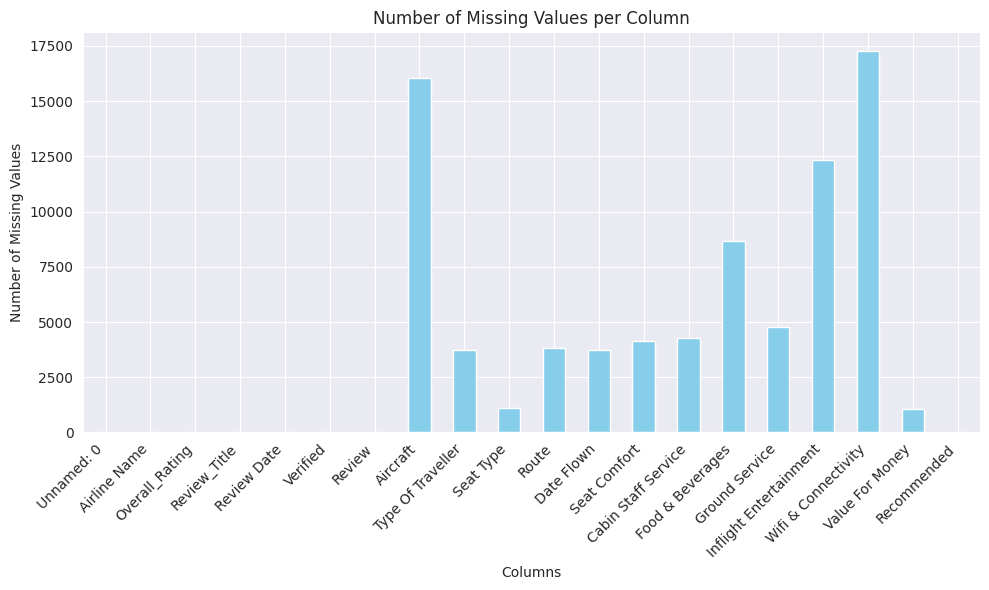

In [ ]:
# Bar chart to visualize the missing values per column
missing_values = df.isnull().sum()
plt.figure(figsize=(10,6))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Number of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Preprocessing

In [ ]:
# Droping rows with missing reviews and dropping one row which is missing the rating for value for money
df.dropna(subset=['Review','Value For Money'], inplace=True)

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
Airline Name,0
Overall_Rating,0
Review_Title,0
Review Date,0
Verified,0
Review,0
Aircraft,14976
Type Of Traveller,2675
Seat Type,42


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22105 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              22105 non-null  int64         
 1   Airline Name            22105 non-null  object        
 2   Overall_Rating          22105 non-null  int8          
 3   Review_Title            22105 non-null  object        
 4   Review Date             22105 non-null  object        
 5   Verified                22105 non-null  bool          
 6   Review                  22105 non-null  object        
 7   Aircraft                7129 non-null   object        
 8   Type Of Traveller       19430 non-null  object        
 9   Seat Type               22063 non-null  object        
 10  Route                   19340 non-null  object        
 11  Date Flown              19415 non-null  datetime64[ns]
 12  Seat Comfort            19016 non-null  float64    

In [ ]:
# Droping irrelevant columns
df.drop(columns=['Unnamed: 0','Review Date', 'Aircraft','Review_Title',
                 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown','Airline Name'],
        inplace=True)

In [ ]:
df.isnull().sum()

,0
Overall_Rating,0
Verified,0
Review,0
Seat Comfort,3089
Cabin Staff Service,3194
Food & Beverages,7605
Ground Service,3727
Inflight Entertainment,11276
Wifi & Connectivity,16185
Value For Money,0


In [ ]:
#Dropping the rows which 'Food & Beverages', 'Ground Service',
#'Cabin Staff Service',and 'Seat Comfort'  is null.
df = df.dropna(axis = 0, subset = ['Food & Beverages','Ground Service',
                                   'Cabin Staff Service','Seat Comfort'])

In [ ]:
# Creating binary indicators for highly missing data while keeping the original columns
for column in ['Inflight Entertainment', 'Wifi & Connectivity']:
    # Create a new column in df to indicate missingness
    df[column + '_missing'] = df[column].isnull().astype(int)

print(df.head())
print(df[['Inflight Entertainment', 'Inflight Entertainment_missing',
         'Wifi & Connectivity', 'Wifi & Connectivity_missing']].head())

   Overall_Rating  Verified  \
0               9      True   
1               1      True   
2               1      True   
4               1      True   
5               1      True   

                                              Review  Seat Comfort  \
0    Moroni to Moheli. Turned out to be a pretty ...           4.0   
1   Moroni to Anjouan. It is a very small airline...           2.0   
2    Anjouan to Dzaoudzi. A very small airline an...           2.0   
4   Do not book a flight with this airline! My fr...           1.0   
5    Had very bad experience with rerouted and ca...           1.0   

   Cabin Staff Service  Food & Beverages  Ground Service  \
0                  5.0               4.0             4.0   
1                  2.0               1.0             1.0   
2                  1.0               1.0             1.0   
4                  1.0               1.0             1.0   
5                  1.0               1.0             1.0   

   Inflight Entertainment  Wifi

In [ ]:
# Simple Imputation for Inflight Entertainment and Wifi & Connectivity
# We use a constant like -1 to denote missing values since these are ordinal ratings
simple_imputer = SimpleImputer(strategy='constant', fill_value=-1)
df[['Inflight Entertainment', 'Wifi & Connectivity']] = simple_imputer.fit_transform(
    df[['Inflight Entertainment', 'Wifi & Connectivity']])

df.isnull().sum()

,0
Overall_Rating,0
Verified,0
Review,0
Seat Comfort,0
Cabin Staff Service,0
Food & Beverages,0
Ground Service,0
Inflight Entertainment,0
Wifi & Connectivity,0
Value For Money,0


This graph shows 'Overall_Rating' for verified (True) and unverified (False) reviews.

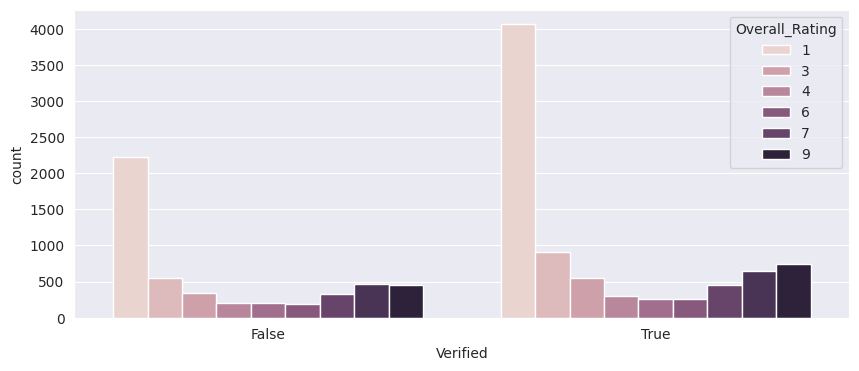

In [ ]:
sns.set_style("darkgrid")
sns.set_palette("viridis")
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(data=df, x='Verified', hue='Overall_Rating', ax=ax)
plt.show()

 we will focus only on the verified reviews to ensure data reliability.

In [ ]:
# Filtering the dataset to include only verified reviews
df = df[df['Verified'] == True]

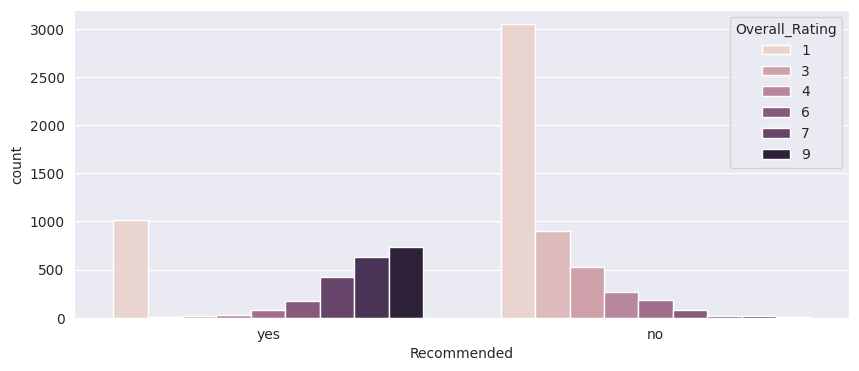

In [ ]:
sns.set_style("darkgrid")
sns.set_palette("viridis")
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(data=df, x='Recommended', hue='Overall_Rating', ax=ax)
plt.show()

From the above graph, we can see that around 1000 people wrote terrible reviews and still recommend the airline. This could be due to various reasons.
The reviewer may have had a positive experience altogether but may have faced a critical issue that made them give a bad review, like they had good food, wifi, seat comfort, and all but may have faced bad cabin staff service which made them give the bad review.
For this type of scenario, we can use topic modeling which will help us to identify the driving factor for the sentiment the review has.





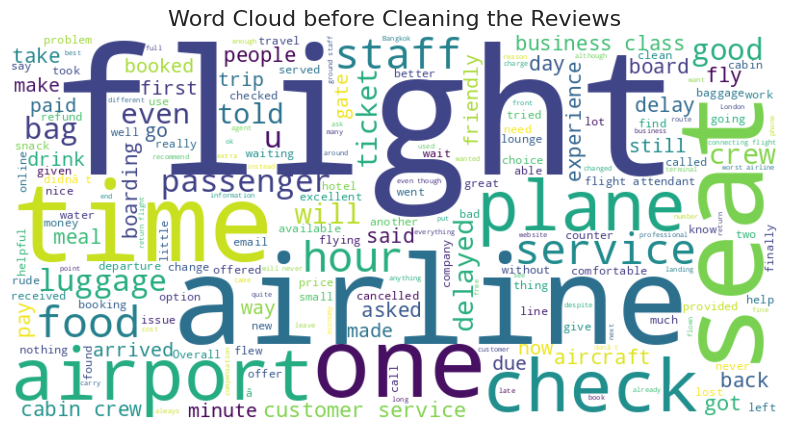

In [ ]:
# Generating a word cloud before cleaning the reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(df['Review']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud before Cleaning the Reviews', fontsize=16)
plt.show()

# Cleaning the reviews

In [ ]:
# Downloading stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Removing non-alphanumeric characters
    text = text.lower()  # Converting to lowercase
    text = word_tokenize(text)  # Tokenizing the text
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text
            if word not in stopwords.words('english')]  # Remove stopwords and lemmatize
    return ' '.join(text)

# Applying the preprocessing function to the 'Review' column
df['Cleaned_Review'] = df['Review'].apply(clean_text)

print(df[['Review', 'Cleaned_Review']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                              Review  \
0    Moroni to Moheli. Turned out to be a pretty ...   
1   Moroni to Anjouan. It is a very small airline...   
2    Anjouan to Dzaoudzi. A very small airline an...   
4   Do not book a flight with this airline! My fr...   
5    Had very bad experience with rerouted and ca...   

                                      Cleaned_Review  
0  moroni moheli turned pretty decent airline onl...  
1  moroni anjouan small airline ticket advised tu...  
2  anjouan dzaoudzi small airline airline based c...  
4  book flight airline friend returned sofia amst...  
5  bad experience rerouted cancelled flight last ...  


In [ ]:
# Vectorizing the text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000,stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Cleaned_Review'])

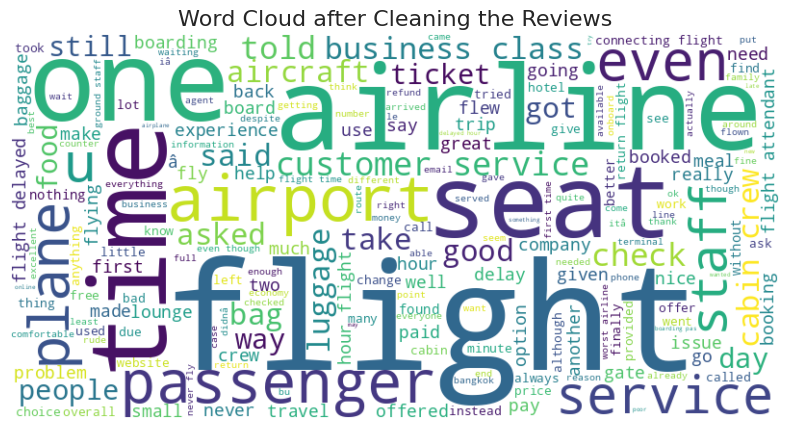

In [ ]:
# word cloud after cleaning the review
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(df['Cleaned_Review']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud after Cleaning the Reviews', fontsize=16)
plt.show()

# Implementing a Logistic Regression Model
## Sentiment Labeling
Now we are labeling each review with a sentiment score such as positive, negative, or neutral using a pre-built sentiment analysis tool VADER.

In [ ]:
nltk.download('vader_lexicon')
# Initializing VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Applying sentiment analysis to each review
df['sentiment_score'] = df['Cleaned_Review'].apply(
    lambda review: sid.polarity_scores(review)['compound'])

# Categorizing sentiment into positive, negative, or neutral
df['sentiment'] = df['sentiment_score'].apply(lambda score: 'positive' if score
                                              > 0.05 else 'negative' if score
                                              < -0.05 else 'neutral')

print(df[['Cleaned_Review', 'sentiment_score', 'sentiment']].head())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                      Cleaned_Review  sentiment_score  \
0  moroni moheli turned pretty decent airline onl...           0.9217   
1  moroni anjouan small airline ticket advised tu...          -0.0258   
2  anjouan dzaoudzi small airline airline based c...           0.8122   
4  book flight airline friend returned sofia amst...           0.6249   
5  bad experience rerouted cancelled flight last ...          -0.5267   

  sentiment  
0  positive  
1   neutral  
2  positive  
4  positive  
5  negative  


# Sentiment Prediction

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Encoding the sentiment labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

# Splitting the data for sentiment prediction
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix,
                                                    df['sentiment_encoded'],
                                                    test_size=0.2,
                                                    random_state=42)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Checking the time for comparison
start_time = time.time()

# Initialize Logistic Regression classifier with class weights
classifier = LogisticRegression(random_state=42, class_weight=class_weight_dict)

classifier.fit(X_train, y_train)

end_time = time.time()
logistic_regression_time = end_time - start_time

# Predicting sentiments on the test set
y_pred = classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Sentiment Prediction Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))





Sentiment Prediction Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.89      0.83       689
     neutral       0.00      0.00      0.00        33
    positive       0.90      0.82      0.86       913

    accuracy                           0.83      1635
   macro avg       0.56      0.57      0.57      1635
weighted avg       0.84      0.83      0.83      1635

Confusion Matrix:
[[611  13  65]
 [ 18   0  15]
 [147  15 751]]


# Topic Modeling
Applying topic modeling using Latent Dirichlet Allocation (LDA) to identify the key topics within the reviews.

In [ ]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tfidf_matrix)

# Displaying the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[
            :-no_top_words - 1:-1]]))

no_top_words = 10
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda, tfidf_feature_names, no_top_words)


Topic 1:
5hrs vueling ravn la der austin die da pour underwhelming
Topic 2:
flight seat good crew food cabin service meal time class
Topic 3:
windhoek nepal fuzhou sriwijaya virus namibia sultan nur joon yogyakarta
Topic 4:
garuda escorted indonesia volotea et panama vip ga penang est
Topic 5:
stroller sofia shape bulgaria fco quito paulo pet sao im
Topic 6:
southern rex thank staff guangzhou china helped service crew helpful
Topic 7:
maroc casablanca royal cleanliness bandar zip seri ke belfast begawan
Topic 8:
addis ethiopian ababa 15kg siem reap antalya kwi iran lome
Topic 9:
fiji makassar nadi adria tunis ljubljana screwed cana sorong kota
Topic 10:
flight airline hour luggage time customer bag airport service day


Analyzing the relationship between identified topics and sentiment.

sentiment       negative  neutral  positive
dominant_topic                             
0                    8.0      1.0       0.0
1                  423.0     41.0    2940.0
3                    2.0      0.0       5.0
5                    1.0      0.0      81.0
7                    0.0      0.0       1.0
8                    1.0      0.0       0.0
9                 2969.0    104.0    1597.0


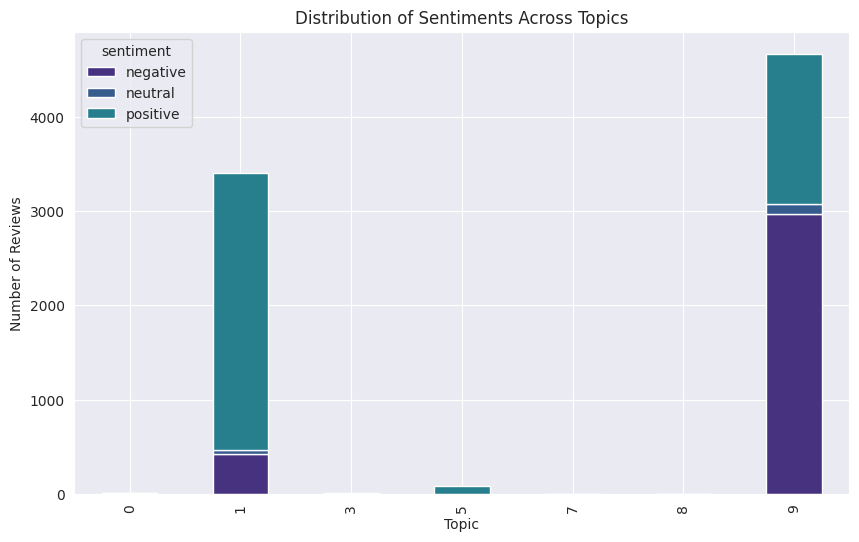

In [ ]:
# Assigning the dominant topic to each review
df['dominant_topic'] = lda.transform(tfidf_matrix).argmax(axis=1)

# Grouping by sentiment and dominant topic to analyze relationships
topic_sentiment_analysis = df.groupby(['dominant_topic', 'sentiment']
                                      ).size().unstack().fillna(0)
print(topic_sentiment_analysis)

# visualising this relationship
topic_sentiment_analysis.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Sentiments Across Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.show()


# Sentiment Analysis with BERT

In [ ]:
# Encoding the sentiment labels into numerical form
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

In [ ]:
# Spliting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(df['Review'],
                                                    df['sentiment_encoded'],
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
# Defining a dataset class for BERT
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = self.reviews[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True # Explicity setting truncation to true
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# Initialising the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Creating data loaders
train_dataset = ReviewsDataset(X_train.tolist(), y_train.tolist(),
                               tokenizer, max_len=128)
test_dataset = ReviewsDataset(X_test.tolist(), y_test.tolist(),
                              tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training the BERT Model

In [ ]:
# Loading BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=3)  # 3 classes, positive, negative, and neutral
start_time = time.time()

# Defining training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

end_time = time.time()
bert_time = end_time - start_time


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.161200
20,1.115500
30,1.043600
40,0.974200
50,0.900600
60,0.836600
70,0.764400
80,0.694600
90,0.676000
100,0.597400


# Model Evaluation

In [ ]:
# Evaluating the model
trainer.evaluate()

# Predicting sentiments on the test set
preds = trainer.predict(test_dataset)
preds = preds.predictions.argmax(-1)

# Evaluating performance
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.2f}")

precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds,
                                                           average='weighted')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

Accuracy: 0.85
Precision: 0.83, Recall: 0.85, F1-Score: 0.84


# Topic Modeling with BERTopic




In [ ]:
!pip install transformers sentence-transformers

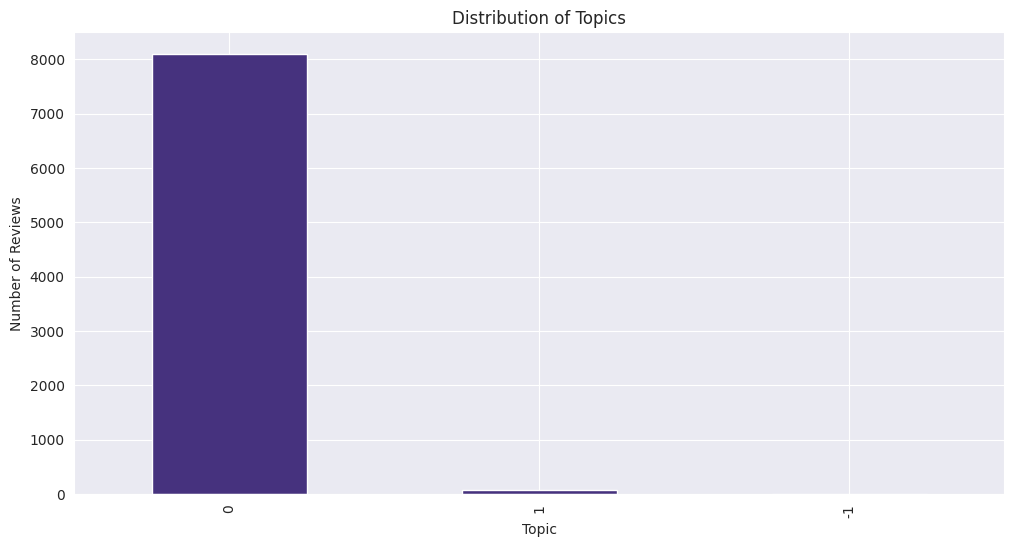

In [ ]:
reviews = df['Cleaned_Review'].tolist()
n_topics =40 # no.of topics
# Parameter tuning
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=15, n_components=n_topics, metric='cosine')

# Initialising BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    n_gram_range=(1, 3),
    min_topic_size=13,
    top_n_words=10
)

# Fitting the model and transforming reviews into topics
topics, probs = topic_model.fit_transform(reviews)

# Adding topics to the DataFrame
df['Topic'] = topics

# Step 6: Visualize the distribution of topics
topic_distribution = df['Topic'].value_counts()
topic_distribution.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.show()

# Visualising the distibution of sentiment across topics

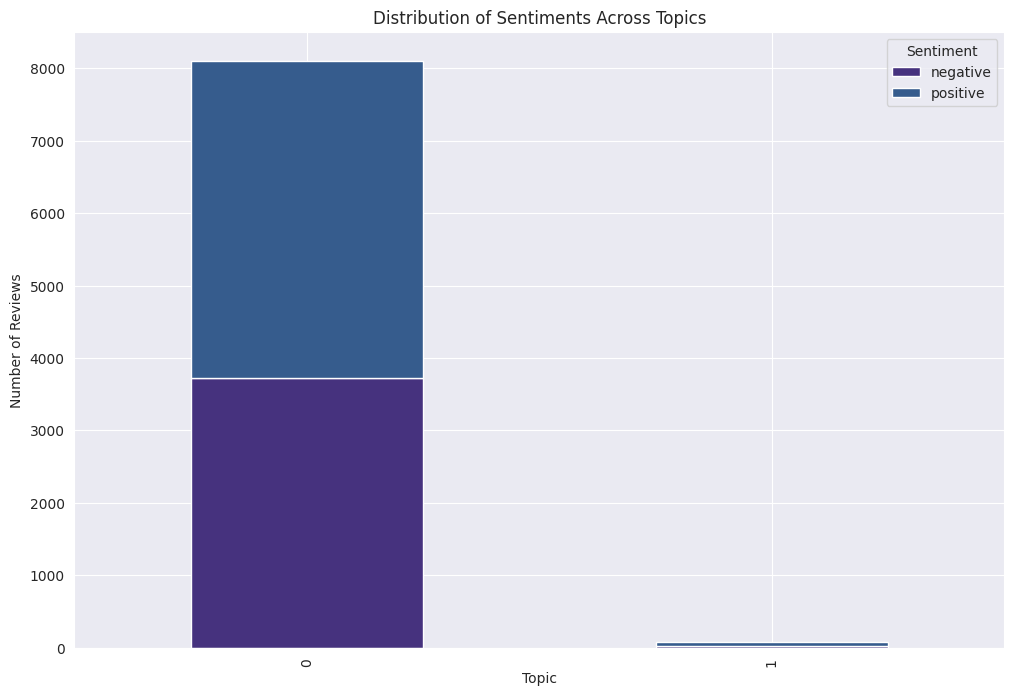

In [ ]:
# Predicting sentiments for the entire dataset
dataset = ReviewsDataset(df['Cleaned_Review'].tolist(),
                         df['sentiment_encoded'].tolist(),
                         tokenizer, max_len=128)
loader = DataLoader(dataset, batch_size=16)

# Making predictions for all reviews
preds_full = trainer.predict(dataset)
preds_full = preds_full.predictions.argmax(-1)

# Adding sentiment predictions to the entire DataFrame
df['Sentiment'] = label_encoder.inverse_transform(preds_full)

df_filtered = df[df['Topic'] != -1]
# Grouping by topic and sentiment to see the distribution
topic_sentiment_analysis = df_filtered.groupby(['Topic', 'Sentiment']
                                      ).size().unstack().fillna(0)

# Visualizing the distribution
topic_sentiment_analysis.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Sentiments Across Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
# Creating descriptive names for each topic based on top words
def get_topic_name(model, topic_id, n_words=3):
    words_info = model.get_topic(topic_id)
    if words_info:
        words = [word for word, _ in words_info[:n_words]]
        topic_name = "_".join(words)
        return topic_name
    else:
        return f"Topic_{topic_id}"  # Default name if no words are found

# Creating a dictionary to map topic numbers to topic names
topic_names = {i: get_topic_name(topic_model, i) for i in range(len(set(topics)))}

# Mapping topic numbers to names in the DataFrame
df['Topic_Name'] = df['Topic'].map(topic_names)


<Figure size 1400x1000 with 0 Axes>

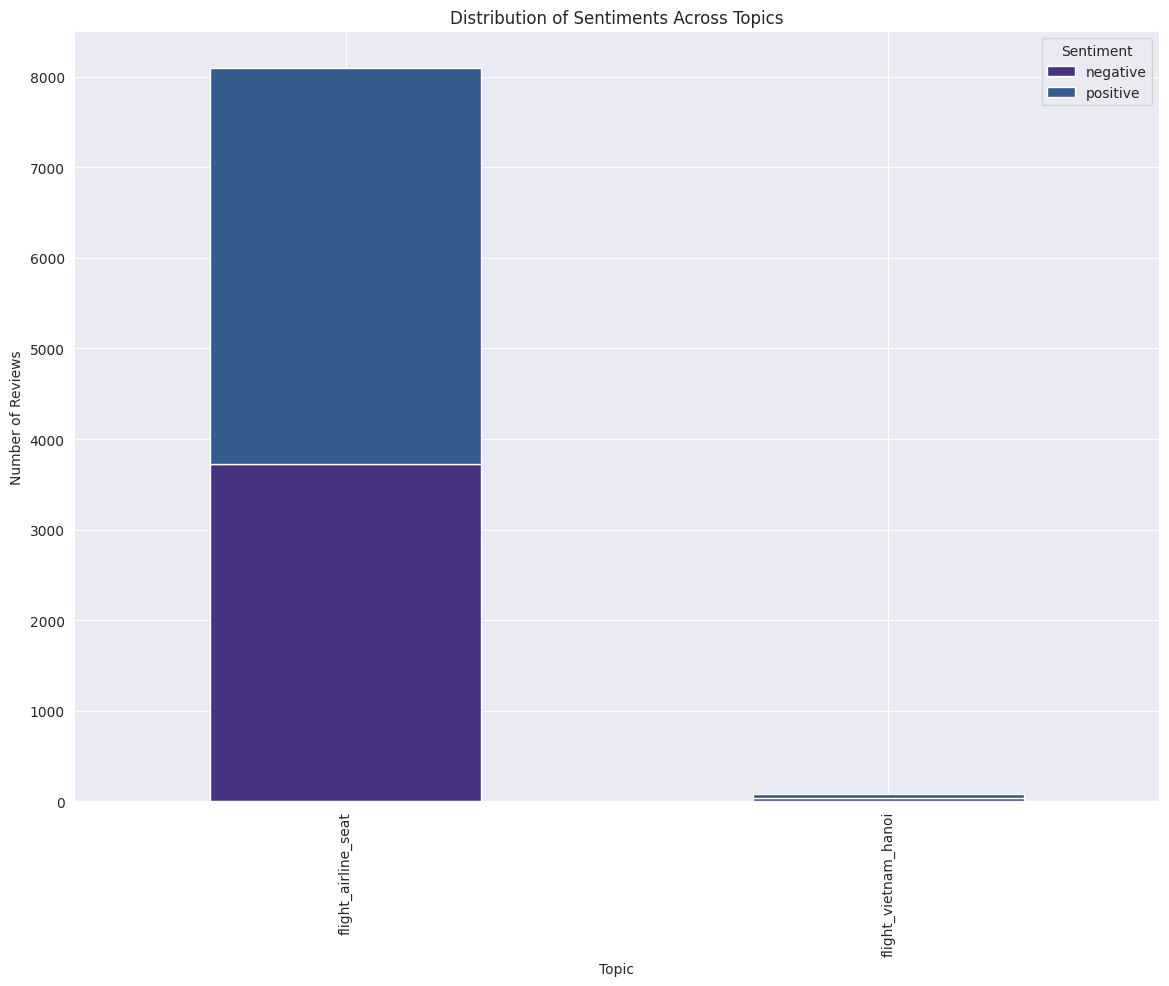

In [ ]:
# Grouping by topic names and sentiment to see the distribution
topic_sentiment_analysis = df.groupby(['Topic_Name', 'Sentiment']
                                      ).size().unstack().fillna(0)

# Visualizing the distribution
plt.figure(figsize=(14, 10))
topic_sentiment_analysis.plot(kind='bar', stacked=True, figsize=(14, 10))
plt.title('Distribution of Sentiments Across Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.show()


For better clarity we will define some predifined topics and their keywords.

In [ ]:
# Defining the keywords for each topic
topic_keywords = {
    'In-flight meal': ['food', 'meal', 'service', 'menu', 'dinner', 'lunch',
                       'breakfast', 'snack', 'beverage', 'drink'],
    'Entertainment': ['entertainment', 'movie', 'tv', 'screen', 'music',
                      'games', 'headphones', 'wifi', 'connectivity', 'video'],
    'Seat comfort': ['seat', 'comfort', 'space', 'legroom', 'recline',
                     'cushion', 'width', 'pitch', 'aisle', 'window'],
    'Staff service': ['staff', 'offered', 'help', 'asked', 'cabin crew',
                      'attendant', 'service', 'friendly', 'rude',
                      'professional'],
    'Check-in process': ['check-in', 'boarding', 'counter', 'queue', 'staff',
                         'ticket', 'passport', 'security', 'boarding pass',
                         'baggage'],
    'Baggage handling': ['baggage', 'luggage', 'suitcase', 'lost', 'found',
                         'delayed', 'damaged', 'weight', 'overweight',
                         'handling'],
    'Flight delay': ['delay', 'late', 'on-time', 'boarding', 'departure',
                     'arrival', 'time', 'schedule', 'cancellation',
                     'postponed'],
    'Flight experience': ['flight', 'smooth', 'turbulence', 'takeoff',
                          'landing', 'pilot', 'experience', 'journey', 'trip',
                          'altitude'],
    'Cleanliness': ['clean', 'dirty', 'hygiene', 'sanitized', 'restroom',
                    'toilet', 'seat', 'cabin', 'trash', 'odor'],
    'Airport facilities': ['airport', 'lounge', 'gate', 'terminal',
                           'facilities', 'restroom', 'wifi', 'shopping',
                           'duty-free', 'parking'],
    'Value for money': ['price', 'cost', 'value', 'money', 'expensive',
                        'cheap', 'worth', 'fare', 'deal', 'budget'],
    'Flight cancellation': ['cancel', 'cancellation', 'refund', 'rebook',
                            'compensation', 'policy', 'notice', 'flight',
                            'schedule', 'delay'],
    'Boarding process': ['boarding', 'process', 'group', 'priority', 'gate',
                         'ticket', 'staff', 'delay', 'zone', 'queue'],
    'Cabin amenities': ['amenities', 'blanket', 'pillow', 'headphones',
                        'magazine', 'reading light', 'air vent', 'tray table',
                        'seat pocket', 'entertainment'],
    'Inflight announcements': ['announcement', 'information', 'pilot', 'clear',
                               'communication', 'crew', 'flight',
                               'instructions', 'loud', 'PA system'],
    'Customer support': ['customer', 'support', 'service', 'call', 'helpline',
                         'response', 'complaint', 'resolve', 'issue',
                         'representative'],
    'Safety measures': ['safety', 'protocol', 'emergency', 'exit', 'mask',
                        'seatbelt', 'instructions', 'demonstration', 'crew',
                        'equipment'],
    'Traveling with kids': ['children', 'kids', 'family', 'stroller',
                            'bassinet', 'meal', 'entertainment', 'seat',
                            'infant', 'child'],
    'Business class experience': ['business class', 'premium', 'upgrade',
                                  'lounge', 'meal', 'seat', 'service',
                                  'comfort', 'privacy', 'priority'],
    'Economy class experience': ['economy class', 'coach', 'budget', 'meal',
                                 'seat', 'service', 'comfort', 'legroom',
                                 'crowded', 'basic'],
    'Frequent flyer benefits': ['frequent flyer', 'miles', 'points',
                                'membership', 'loyalty', 'status', 'upgrade',
                                'benefits', 'rewards', 'airline'],
    'Cabin noise': ['noise', 'quiet', 'engine', 'loud', 'annoying', 'sleep',
                    'earplugs', 'conversation', 'crying baby', 'disturbance'],
    'Immigration process': ['immigration', 'customs', 'passport', 'visa',
                            'security', 'officer', 'line', 'entry',
                            'inspection', 'documents'],
    'Flight duration': ['duration', 'long', 'short', 'time', 'hours',
                        'distance', 'non-stop', 'layover', 'connection',
                        'direct flight'],
    'Onboard purchases': ['purchase', 'buy', 'duty-free', 'snack', 'drink',
                          'merchandise', 'sale', 'shopping', 'payment',
                          'items'],
    'Special assistance': ['assistance', 'wheelchair', 'disability',
                           'elderly', 'special needs', 'help', 'support',
                           'service', 'request', 'accommodation'],
    'Inflight connectivity': ['wifi', 'internet', 'connectivity', 'speed',
                              'signal', 'login', 'data', 'network',
                              'cost', 'availability'],
}


def assign_topic(review):
    for topic, keywords in topic_keywords.items():
        if any(keyword in review.lower() for keyword in keywords):
            return topic
    return 'Other'  # topic if no keywords match

# Applying the function to assign topics
df['Assigned_Topic'] = df['Cleaned_Review'].apply(assign_topic)

# Analyzing the assigned topics
topic_distribution = df['Assigned_Topic'].value_counts()
print(topic_distribution)

Assigned_Topic
In-flight meal             5540
Staff service               891
Seat comfort                700
Check-in process            316
Baggage handling            255
Entertainment               226
Flight delay                165
Flight experience            61
Airport facilities            6
Value for money               6
Cleanliness                   3
Other                         2
Frequent flyer benefits       2
Flight cancellation           1
Name: count, dtype: int64


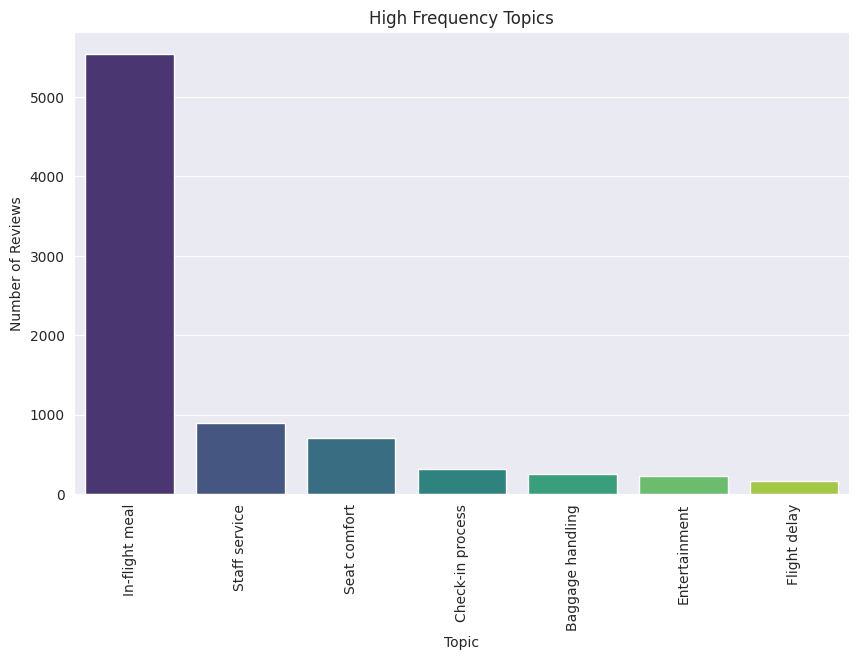

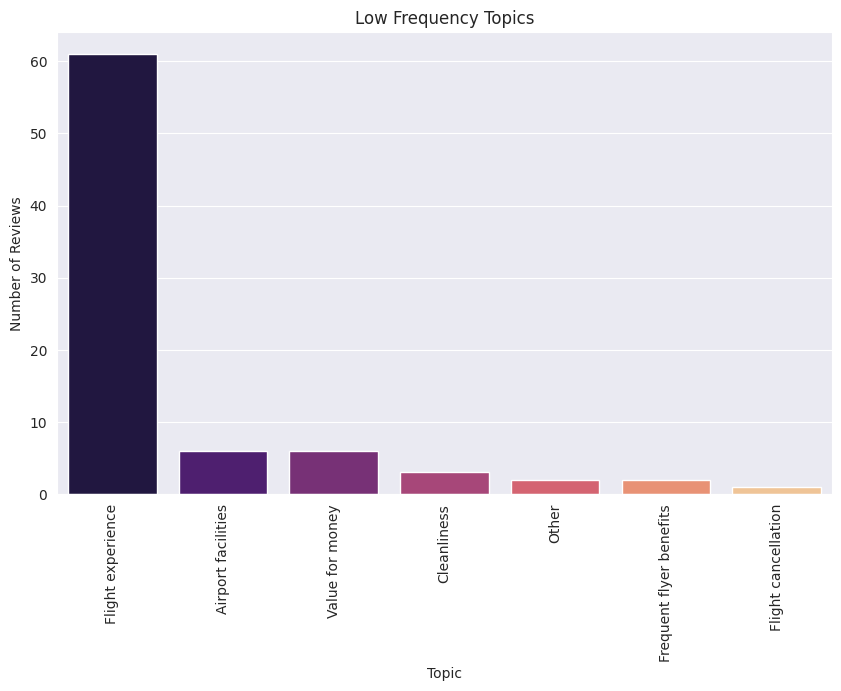

In [ ]:
# Separating topics with high counts from those with low counts better visualisation
high_count_topics = topic_distribution[topic_distribution > 100]
low_count_topics = topic_distribution[topic_distribution <= 100]

# Plotting high-count topics
plt.figure(figsize=(10, 6))
sns.barplot(x=high_count_topics.index, y=high_count_topics.values,
            palette="viridis")
plt.title('High Frequency Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.show()

# Plotting low-count topics
plt.figure(figsize=(10, 6))
sns.barplot(x=low_count_topics.index, y=low_count_topics.values,
            palette="magma")
plt.title('Low Frequency Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.show()

# Distribuition of sentiment across the defined topics

<Figure size 1600x800 with 0 Axes>

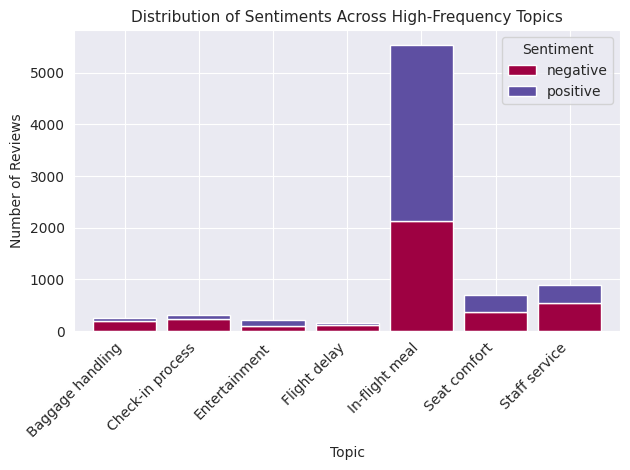

<Figure size 1600x800 with 0 Axes>

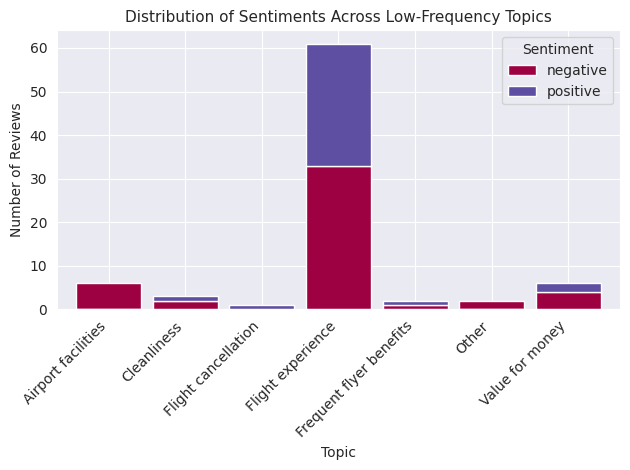

In [ ]:
# Grouping by assigned topic and sentiment
topic_sentiment_analysis = df.groupby(['Assigned_Topic', 'Sentiment']
                                      ).size().unstack().fillna(0)

high_count_topics = topic_sentiment_analysis.loc[topic_sentiment_analysis.sum(
    axis=1) > 100]
low_count_topics = topic_sentiment_analysis.loc[topic_sentiment_analysis.sum(
    axis=1) <= 100]

# Plotting high-count topics
plt.figure(figsize=(16, 8))
high_count_topics.plot(kind='bar', stacked=True, colormap='Spectral', width=0.85)
plt.title('Distribution of Sentiments Across High-Frequency Topics', fontsize=11)
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting low-count topics
plt.figure(figsize=(16, 8))
low_count_topics.plot(kind='bar', stacked=True, colormap='Spectral', width=0.85)
plt.title('Distribution of Sentiments Across Low-Frequency Topics', fontsize=11)
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Custom Neural Network Model


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Applying vectorization
X_train_tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Review'])

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_tfidf,
    df['sentiment_encoded'],
    test_size=0.2,
    random_state=42
)

# Converting to dense format
X_train = X_train.toarray()
X_test = X_test.toarray()



In [ ]:
model = models.Sequential([
    layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu',
                 kernel_regularizer=l2(0.02)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(3, activation='softmax')
])

model.summary()

# Compiling the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Adding Callbacks for preventing overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3,
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001)

start_time = time.time()

# Training the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

end_time = time.time()
self_developed_time = end_time - start_time

# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │         640,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 649,347 (2.48 MB)

 Trainable params: 648,963 (2.48 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5292 - loss: 4.4209 - val_accuracy: 0.5596 - val_loss: 2.0739 - learning_rate: 0.0010
Epoch 2/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8092 - loss: 1.6255 - val_accuracy: 0.6275 - val_loss: 1.2268 - learning_rate: 0.0010
Epoch 3/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8323 - loss: 0.9746 - val_accuracy: 0.8202 - val_loss: 0.7720 - learning_rate: 0.0010
Epoch 4/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8409 - loss: 0.7355 - val_accuracy: 0.8477 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 5/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8418 - loss: 0.6445 - val_accuracy: 0.8550 - val_loss: 0.5655 - learning_rate: 0.0010
Epoch 6/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8428 - loss: 0.6023 - val_accuracy: 0.8391 - val_loss: 0.5719 - learning_rate: 0.0010
Epoch 7/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8476 - loss: 0.5783 -

In [ ]:
# Converting label classes to strings
target_names = [str(i) for i in label_encoder.classes_]

# Making Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Sentiment Prediction Accuracy:", accuracy_score(y_test, y_pred_classes))
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sentiment Prediction Accuracy: 0.8623853211009175
Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.89      0.85       689
     neutral       0.00      0.00      0.00        33
    positive       0.90      0.88      0.89       913

    accuracy                           0.86      1635
   macro avg       0.57      0.59      0.58      1635
weighted avg       0.85      0.86      0.85      1635

Confusion Matrix:
[[611   0  78]
 [ 19   0  14]
 [114   0 799]]


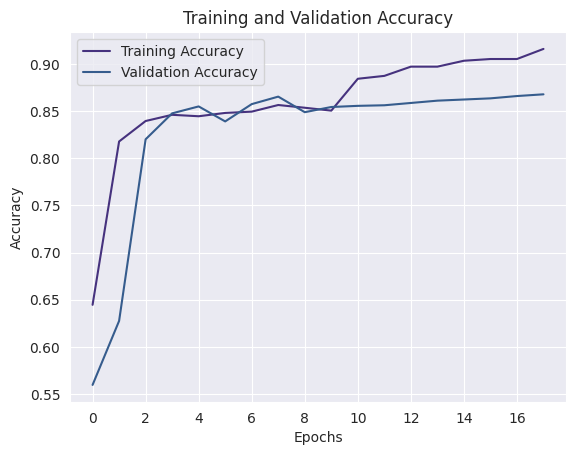

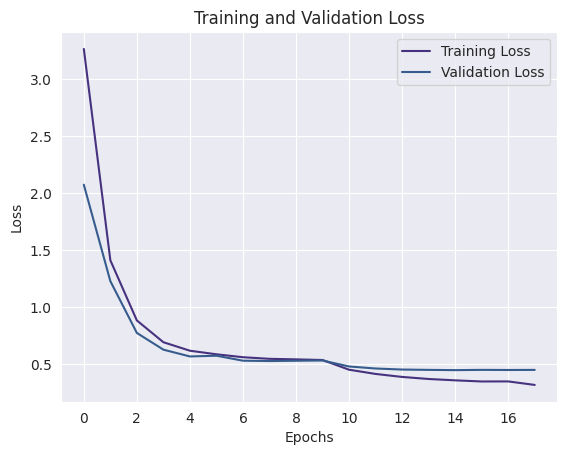

In [ ]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, len(history.history['accuracy']),2))
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, len(history.history['loss']),2))
plt.legend()
plt.show()


<Figure size 1400x800 with 0 Axes>

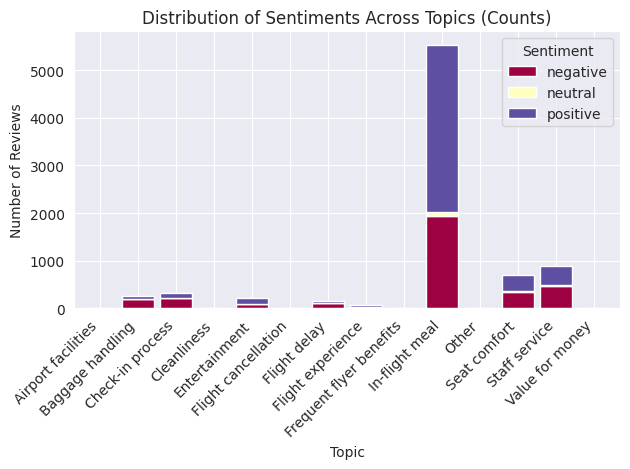

In [ ]:
df['Sentiment'] = label_encoder.inverse_transform(df['sentiment_encoded'])

# Grouping by Topic and Sentiment to get counts
topic_sentiment_counts = df.groupby(['Assigned_Topic', 'Sentiment']
                                    ).size().unstack().fillna(0)

sns.set_palette("Spectral")
# Plotting the sentiment counts across topics
plt.figure(figsize=(14, 8))
topic_sentiment_counts.plot(kind='bar', stacked=True, colormap='Spectral', width=0.85)
plt.title('Distribution of Sentiments Across Topics (Counts)')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

